Algorithm implemented :   
Cluster based anomaly detection (K-mean)   
Repartition of data into categories then Gaussian/Elliptic Enveloppe on each categories separately   
Markov Chain    
Isolation Forest    
One class SVM     
RNN (comparison between prediction and reality)    
https://www.kaggle.com/victorambonati/unsupervised-anomaly-detection    

In [1]:
#%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [2]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        #distance.set_value(i, np.linalg.norm(Xa-Xb))
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

# train markov model to get transition matrix
def getTransitionMatrix (df):
    df = np.array(df)
    model = msm.estimate_markov_model(df, 1)
    return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

In [3]:
df = pd.read_csv('../csv_data/m_data_fromNow.csv', usecols=['date', 'time', 'cpu'])
df.head()

,date,time,cpu
0,2020-07-04,00:10:00,2.398816
1,2020-07-04,00:20:00,2.370533
2,2020-07-04,00:30:00,2.670351
3,2020-07-04,00:40:00,2.578600
4,2020-07-04,00:50:00,2.583533


In [4]:
df['timestamp'] = df[df.columns[0:2]]. apply(
    lambda x: ' '.join(x.dropna().astype(str)),
    axis=1)
df.head()

,date,time,cpu,timestamp
0,2020-07-04,00:10:00,2.398816,2020-07-04 00:10:00
1,2020-07-04,00:20:00,2.370533,2020-07-04 00:20:00
2,2020-07-04,00:30:00,2.670351,2020-07-04 00:30:00
3,2020-07-04,00:40:00,2.578600,2020-07-04 00:40:00
4,2020-07-04,00:50:00,2.583533,2020-07-04 00:50:00


In [5]:
df = df[['timestamp', 'cpu']]
df.head()

,timestamp,cpu
0,2020-07-04 00:10:00,2.398816
1,2020-07-04 00:20:00,2.370533
2,2020-07-04 00:30:00,2.670351
3,2020-07-04 00:40:00,2.578600
4,2020-07-04 00:50:00,2.583533


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477 entries, 0 to 1476
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  1477 non-null   object 
 1   cpu        1477 non-null   float64
dtypes: float64(1), object(1)
memory usage: 23.2+ KB
None


In [7]:
print(df['timestamp'].head())

0    2020-07-04 00:10:00
1    2020-07-04 00:20:00
2    2020-07-04 00:30:00
3    2020-07-04 00:40:00
4    2020-07-04 00:50:00
Name: timestamp, dtype: object


In [8]:
print(df['cpu'].mean())

2.4504714139775414


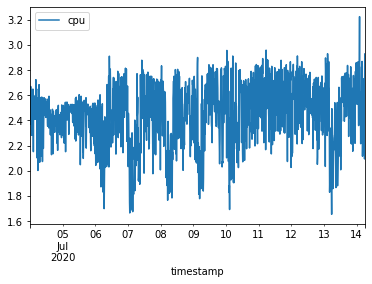

In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.plot(x = 'timestamp', y='cpu')

In [10]:
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 8) & (df['hours'] <= 19)).astype(int)
df.head(30)

,timestamp,cpu,hours,daylight
0,2020-07-04 00:10:00,2.398816,0,0
1,2020-07-04 00:20:00,2.370533,0,0
2,2020-07-04 00:30:00,2.670351,0,0
3,2020-07-04 00:40:00,2.578600,0,0
4,2020-07-04 00:50:00,2.583533,0,0
5,2020-07-04 01:00:00,2.638800,1,0
6,2020-07-04 01:10:00,2.281600,1,0
7,2020-07-04 01:20:00,2.591516,1,0
8,2020-07-04 01:30:00,2.308118,1,0
9,2020-07-04 01:40:00,2.637456,1,0


In [11]:
s = pd.date_range('2020-06-29', '2020-07-10').to_series()
s.dt.dayofweek

2020-06-29    0
2020-06-30    1
2020-07-01    2
2020-07-02    3
2020-07-03    4
2020-07-04    5
2020-07-05    6
2020-07-06    0
2020-07-07    1
2020-07-08    2
2020-07-09    3
2020-07-10    4
Freq: D, dtype: int64

In [12]:
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
outliers_fraction = 0.01


In [13]:
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [14]:
df['categories'] = df['WeekDay']*2 + df['daylight']


a = df.loc[df['categories'] == 0, 'cpu']
b = df.loc[df['categories'] == 1, 'cpu']
c = df.loc[df['categories'] == 2, 'cpu']
d = df.loc[df['categories'] == 3, 'cpu']


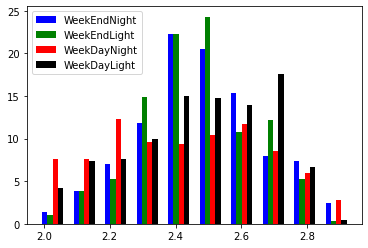

In [15]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.rcParams['figure.figsize'] = [10, 5]
plt.legend()


In [16]:
# Take useful feature and standardize them
data = df[['cpu', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

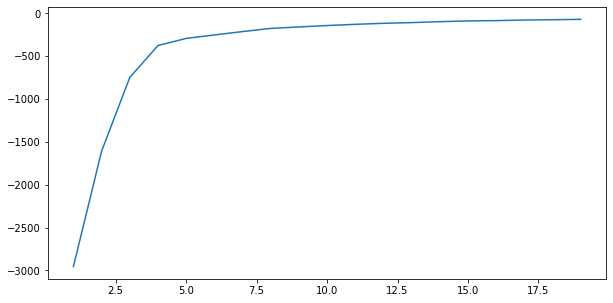

In [17]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)

In [18]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

14    174
12    134
5     124
6     108
0     107
7     105
9     104
11    103
3      87
1      85
10     83
4      71
8      65
2      65
13     62
Name: cluster, dtype: int64

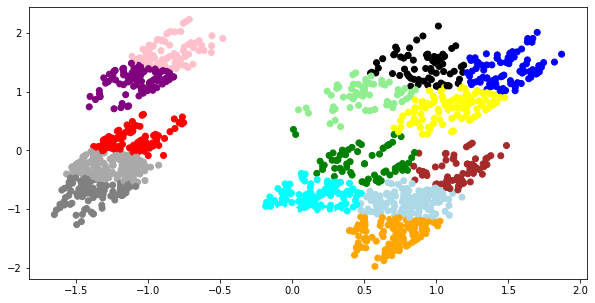

In [19]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [20]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


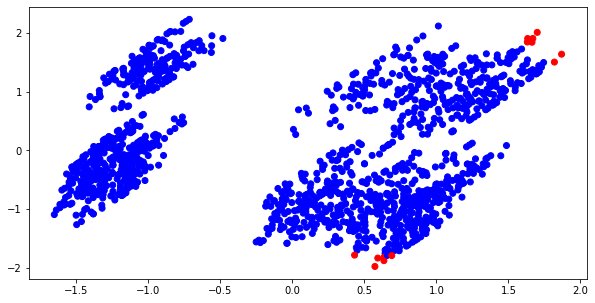

In [21]:
fig, ax = plt.subplots()
color = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: color[x]))
plt.show()

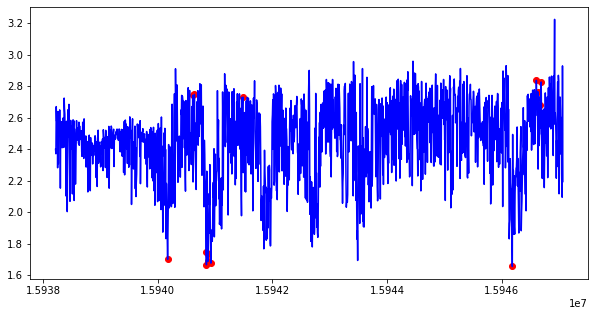

In [22]:
fig, ax = plt.subplots()
a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'cpu']] #anomaly

ax.plot(df['time_epoch'], df['cpu'], color = 'blue')
ax.scatter(a['time_epoch'], a['cpu'], color = 'red')
plt.show()

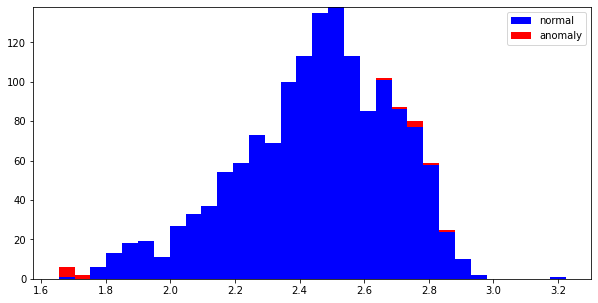

In [23]:
a = df.loc[df['anomaly21'] == 0, 'cpu']
b = df.loc[df['anomaly21'] == 1, 'cpu']

fig, axs = plt.subplots()
axs.hist([a, b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

## Categories + Gaussian

In [24]:
# creation of 4 differents data set based on categories defined before
df_class0 = df.loc[df['categories'] == 0, 'cpu']
df_class1 = df.loc[df['categories'] == 1, 'cpu']
df_class2 = df.loc[df['categories'] == 2, 'cpu']
df_class3 = df.loc[df['categories'] == 3, 'cpu']

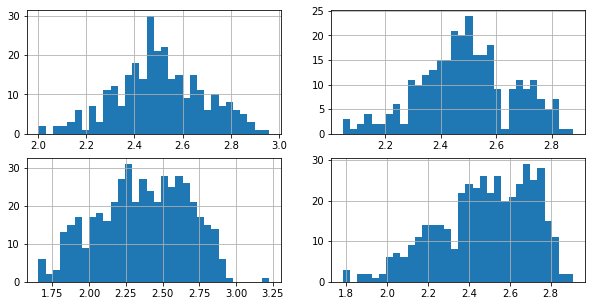

In [25]:
# plot the temperature repartition by categories
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

In [26]:
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

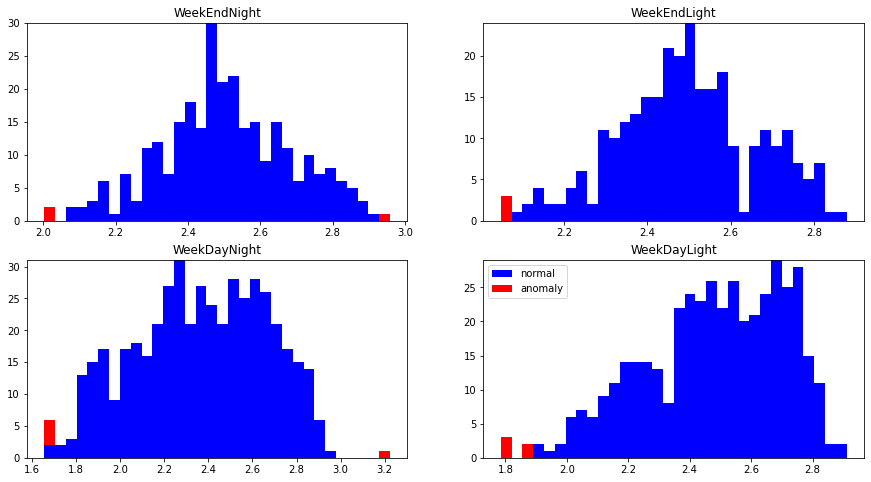

In [27]:
# plot the temperature repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'cpu']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'cpu']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'cpu']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'cpu']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'cpu']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'cpu']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'cpu']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'cpu']

plt.rcParams['figure.figsize'] = [15, 8]
fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [28]:
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(float)

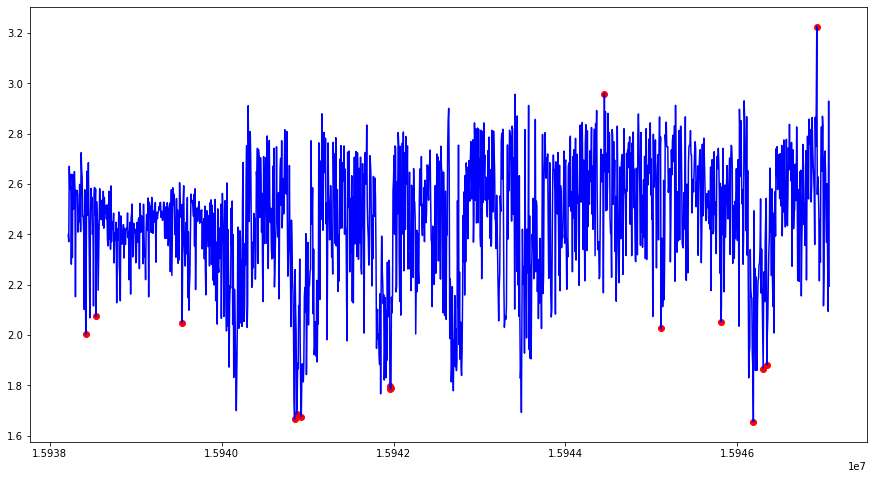

In [29]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'cpu')] #anomaly

ax.plot(df['time_epoch'], df['cpu'], color='blue')
ax.scatter(a['time_epoch'], a['cpu'], color='red')
plt.show()

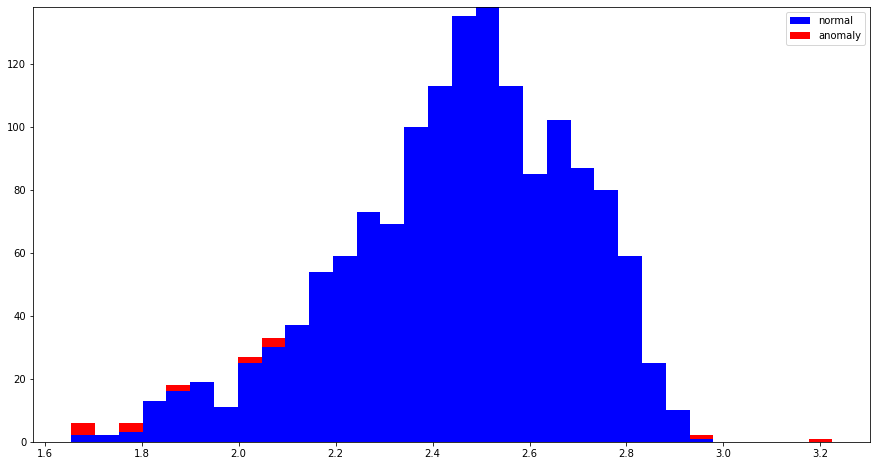

In [30]:
a = df.loc[df['anomaly22'] == 0, 'cpu']
b = df.loc[df['anomaly22'] == 1, 'cpu']

fig, axs = plt.subplots()
axs.hist([a, b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

## Markov chains

In [31]:
x1 = (df['cpu'] <= 18).astype(int)
x2 = ((df['cpu'] > 18) & (df['cpu'] <= 21)).astype(int)
x3 = ((df['cpu'] > 21) & (df['cpu'] <= 24)).astype(int)
x4 = ((df['cpu'] > 24) & (df['cpu'] <= 27)).astype(int)
x5 = (df['cpu'] > 27).astype(int)
df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5
print(df_mm)


0       1
1       1
2       1
3       1
4       1
       ..
1472    1
1473    1
1474    1
1475    1
1476    1
Name: cpu, Length: 1477, dtype: int64


## Isolation Forest

In [32]:
data = df[['cpu', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

0    1462
1      15
Name: anomaly25, dtype: int64


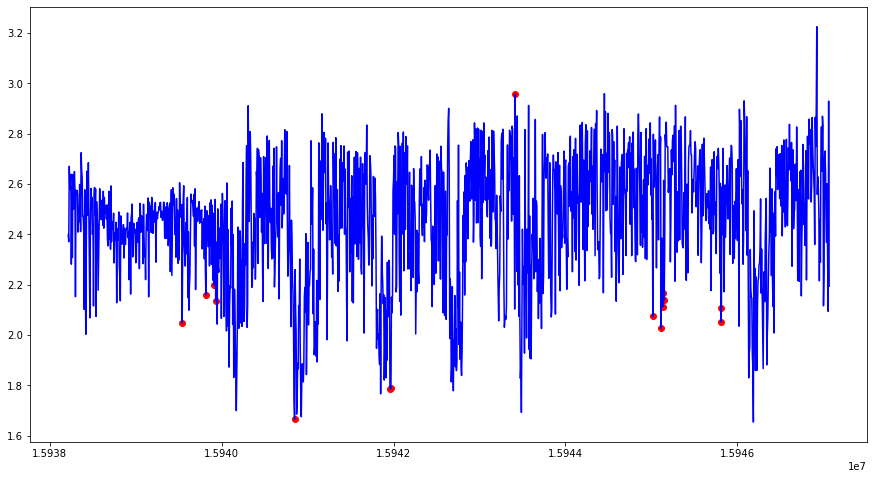

In [33]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'cpu']] #anomaly

ax.plot(df['time_epoch'], df['cpu'], color='blue')
ax.scatter(a['time_epoch'],a['cpu'], color='red')
plt.show()

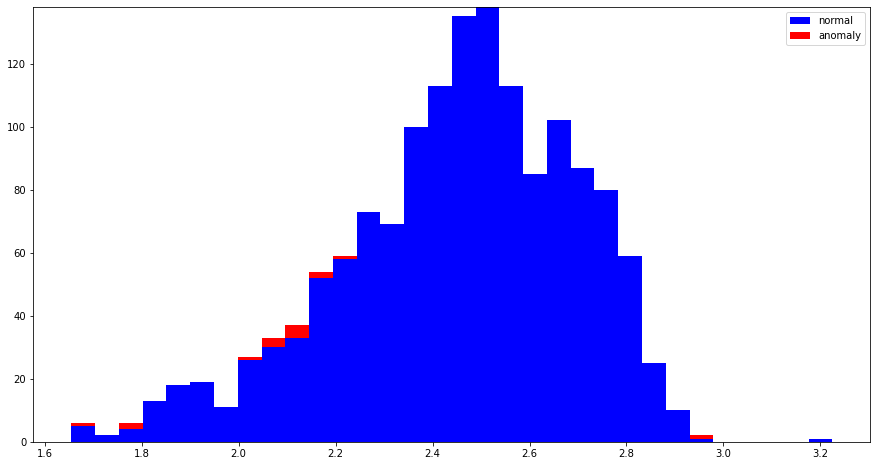

In [34]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly25'] == 0, 'cpu']
b = df.loc[df['anomaly25'] == 1, 'cpu']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

## One class SVM

In [35]:
# Take useful feature and standardize them 
data = df[['cpu', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

0    1460
1      17
Name: anomaly26, dtype: int64


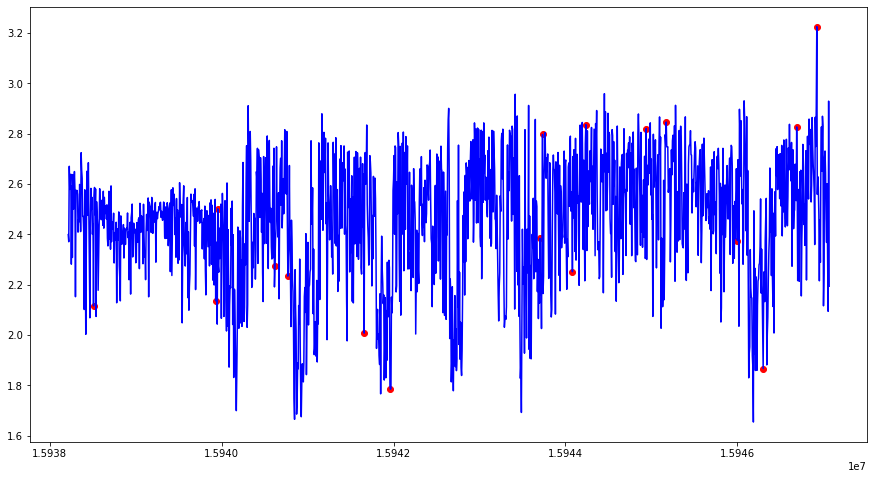

In [36]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'cpu']] #anomaly

ax.plot(df['time_epoch'], df['cpu'], color='blue')
ax.scatter(a['time_epoch'],a['cpu'], color='red')
plt.show()

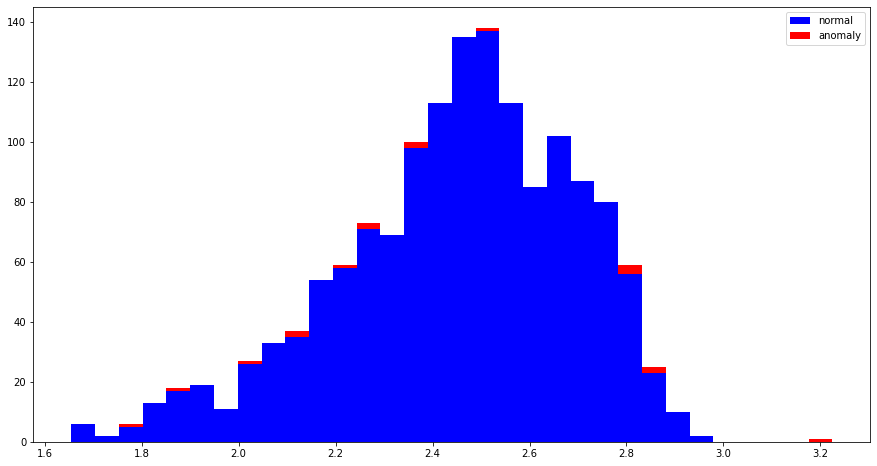

In [37]:
a = df.loc[df['anomaly26'] == 0, 'cpu']
b = df.loc[df['anomaly26'] == 1, 'cpu']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

# RNN

In [38]:
#select and standardize data
data_n = df[['cpu', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 295
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#total_row = data_n.index.stop
#prediction_time = 1 
#testdatasize = int(total_row - (total_row * 0.95))
#unroll_length = int(total_row * 0.05)
#testdatacut = testdatasize + unroll_length + 1

x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut][0].values


# test data
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:  ][0].values


In [39]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1080, 50, 5)
y_train (1080,)
x_test (295, 50, 5)
y_test (295,)


In [40]:
# specific libraries for RNN
# keras is a high layer build on Tensorflow layer to stay in high level/easy implementation
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys

In [41]:
### CJB : 파라미터 다시 확인 후 조절할 것

# Build the model
model = Sequential()
model.add(LSTM(100, input_shape = (50, 5), return_sequences = True)) 
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()
print('compilation time : {}'.format(time.time() - start))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           42400     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 122,901
Trainable params: 122,901
Non-trainable params: 0
__________________________________________________

In [42]:
model.fit(x_train, y_train, batch_size=100, epochs=500, validation_split=0.1)

Epoch 1/500
10/10 [==============================] - 3s 258ms/step - loss: 0.8150 - val_loss: 1.1020
Epoch 2/500
10/10 [==============================] - 2s 152ms/step - loss: 0.7386 - val_loss: 0.8646
Epoch 3/500
10/10 [==============================] - 2s 156ms/step - loss: 0.7216 - val_loss: 0.8883
Epoch 4/500
10/10 [==============================] - 2s 150ms/step - loss: 0.7096 - val_loss: 0.8946
Epoch 5/500
10/10 [==============================] - 2s 152ms/step - loss: 0.7076 - val_loss: 0.9395
Epoch 6/500
10/10 [==============================] - 2s 178ms/step - loss: 0.7028 - val_loss: 0.9389
Epoch 7/500
10/10 [==============================] - 1s 148ms/step - loss: 0.7123 - val_loss: 0.9821
Epoch 8/500
10/10 [==============================] - 2s 161ms/step - loss: 0.7000 - val_loss: 0.9405
Epoch 9/500
10/10 [==============================] - 2s 163ms/step - loss: 0.7008 - val_loss: 0.9442
Epoch 10/500
10/10 [==============================] - 1s 150ms/step - loss: 0.6837 - val_lo

Epoch 161/500
10/10 [==============================] - 2s 152ms/step - loss: 0.3626 - val_loss: 1.3500
Epoch 162/500
10/10 [==============================] - 2s 165ms/step - loss: 0.3837 - val_loss: 1.4582
Epoch 163/500
10/10 [==============================] - 2s 165ms/step - loss: 0.3779 - val_loss: 1.4930
Epoch 164/500
10/10 [==============================] - 2s 156ms/step - loss: 0.3662 - val_loss: 1.2728
Epoch 165/500
10/10 [==============================] - 2s 151ms/step - loss: 0.3774 - val_loss: 1.2352
Epoch 166/500
10/10 [==============================] - 2s 157ms/step - loss: 0.3734 - val_loss: 1.2706
Epoch 167/500
10/10 [==============================] - 2s 151ms/step - loss: 0.3762 - val_loss: 1.2225
Epoch 168/500
10/10 [==============================] - 2s 164ms/step - loss: 0.3652 - val_loss: 1.1406
Epoch 169/500
10/10 [==============================] - 2s 150ms/step - loss: 0.3679 - val_loss: 1.2761
Epoch 170/500
10/10 [==============================] - 2s 152ms/step - lo

10/10 [==============================] - 2s 163ms/step - loss: 0.1873 - val_loss: 1.5096
Epoch 320/500
10/10 [==============================] - 1s 148ms/step - loss: 0.1792 - val_loss: 1.4837
Epoch 321/500
10/10 [==============================] - 2s 150ms/step - loss: 0.1724 - val_loss: 1.5017
Epoch 322/500
10/10 [==============================] - 2s 156ms/step - loss: 0.1747 - val_loss: 1.4324
Epoch 323/500
10/10 [==============================] - 2s 161ms/step - loss: 0.1712 - val_loss: 1.5188
Epoch 324/500
10/10 [==============================] - 2s 160ms/step - loss: 0.1776 - val_loss: 1.4238
Epoch 325/500
10/10 [==============================] - 1s 147ms/step - loss: 0.1579 - val_loss: 1.5693
Epoch 326/500
10/10 [==============================] - 2s 155ms/step - loss: 0.1779 - val_loss: 1.5199
Epoch 327/500
10/10 [==============================] - 2s 160ms/step - loss: 0.1586 - val_loss: 1.4917
Epoch 328/500
10/10 [==============================] - 1s 149ms/step - loss: 0.1637 - v

10/10 [==============================] - 1s 147ms/step - loss: 0.0823 - val_loss: 1.3764
Epoch 478/500
10/10 [==============================] - 2s 164ms/step - loss: 0.0812 - val_loss: 1.3094
Epoch 479/500
10/10 [==============================] - 2s 153ms/step - loss: 0.0771 - val_loss: 1.3646
Epoch 480/500
10/10 [==============================] - 2s 154ms/step - loss: 0.0694 - val_loss: 1.3777
Epoch 481/500
10/10 [==============================] - 2s 156ms/step - loss: 0.0743 - val_loss: 1.3376
Epoch 482/500
10/10 [==============================] - 2s 158ms/step - loss: 0.0800 - val_loss: 1.4148
Epoch 483/500
10/10 [==============================] - 1s 149ms/step - loss: 0.0873 - val_loss: 1.3796
Epoch 484/500
10/10 [==============================] - 2s 153ms/step - loss: 0.0859 - val_loss: 1.4508
Epoch 485/500
10/10 [==============================] - 2s 157ms/step - loss: 0.0827 - val_loss: 1.5076
Epoch 486/500
10/10 [==============================] - 2s 151ms/step - loss: 0.0805 - v

In [43]:
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

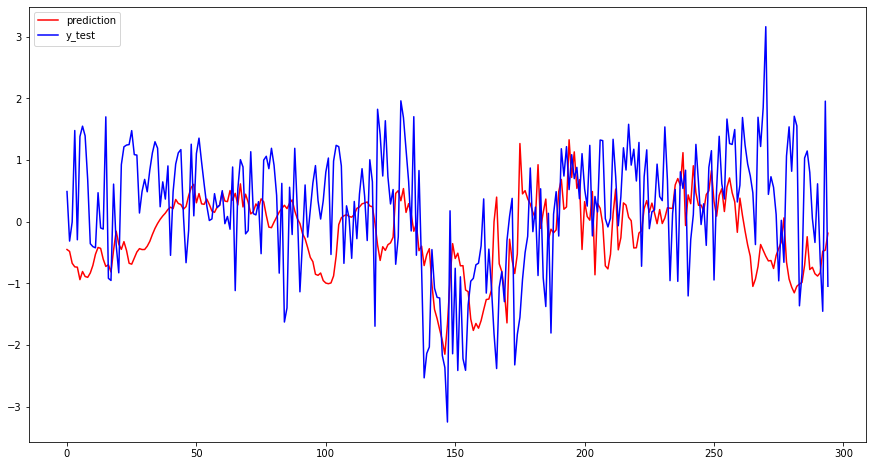

In [44]:
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()